
<p align="center">
    <img src="https://github.com/GeostatsGuy/GeostatsPy/blob/master/TCG_color_logo.png?raw=true" width="220" height="240" />

</p>

## Subsurface Data Analytics 

## K-means Clustering Heuristic


#### Elnara Rustamzade
#### Department of Petroleum and Geosystems Engineering, Cockrell School of Engineering

### Subsurface Machine Learning Course, The University of Texas at Austin
#### Hildebrand Department of Petroleum and Geosystems Engineering, Cockrell School of Engineering
#### Department of Geological Sciences, Jackson School of Geosciences

Supervised and reviewed by:

#### Instructor: Prof. Michael Pyrcz, Ph.D., P.Eng., Associate Professor, The Univeristy of Texas at Austin
##### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Course TA: Ademide Mabadeje, Graduate Student, The University of Texas at Austin
##### [LinkedIn](https://www.linkedin.com/in/ademidemabadeje/)



### Executive summary
We have already studied a technique that allows us to find groups of similar objects that are more related to each other than to objects in other groups. In this project, we will learn about one of the most popular clustering algorithms, k-means. Using sklearn, I performed classic and heuristic k-means clustering and compared the results to see whether Elkan (heuristic) method is faster than classical method or not. According to the sensitivity analysis of three different parameter, it is observed that there are certain conditions under which Elkan is faster and there are also other cases when classical method is should be used instead.

### Import Relevant Packages

In this step, we import the necessary packages required to perform our analysis.

In [1]:
import numpy as np                        # ndarrys for gridded data
import pandas as pd                       # DataFrames for tabular data
import os                                 # set working directory, run executables
import matplotlib.pyplot as plt           # for plotting
import copy                               # for deep copies
from sklearn.cluster import KMeans        # for kmeans clustering function
import datetime                           # for execution time
import random                             # for random number generation

### Data
Instead of working with one dataset, here I generate a random synthetic data frame, which contains "K" number of normally distributed blobs. These blobs are randomly positioned in a Feature space. We will have two features called Feature 1 and Feature 2.

Let's run this command to generate the data and with two columns conditionally named "Feature1" and "Feature2". 

In [2]:
data_size = 500                                                         # Number of data points in each blob
K = 6                                                                   # Number of blobs and later used as number of clusters for KMeans
df = pd.DataFrame([])                                                   # Create an empty DataFrame
for i in range(0,K):                                                    # Create each blob of data points in a loop and add to the DataFrame
    df_ = pd.DataFrame(np.random.normal(size=(data_size,2),scale=3))    # Create a normally distributed blob with certain size and std
    df_.iloc[:,0] = df_.iloc[:,0] + 42*np.random.rand()                 # Change the x position (mean of Feature1) randomly for a blob created above 
    df_.iloc[:,1] = df_.iloc[:,1] + 42*np.random.rand()                 # Change the y position (mean of Feature2) randomly for a blob created above
    df = pd.concat([df,df_])                                            # Add the blob to a main DataFrame
df.columns=['Feature1', 'Feature2']                                     # Set column names as Feature 1 and Feature 2


Let's preview the first 10 samples.

In [3]:
df.head(10)                                                             # Preview the first 10 rows of the data

,Feature1,Feature2
0,2.927309,29.307660
1,6.788312,24.661840
2,0.262554,21.469324
3,-1.484274,26.431037
4,3.296180,22.826311
5,3.982131,23.937512
6,5.097214,26.099978
7,4.953550,26.658400
8,-1.587709,25.148424
9,4.727043,30.698758


### Normalization

From the synthetic data, we can find a minimum and maximum value for each feature.  

* We will use this for normalization and for plotting.

Here we make a normalized version of each predictor feature.  We will scale the variables to range from 0 to 1.  

* There is no distribution shape change.


In [4]:
Feature1min = df['Feature1'].min(); Feature1max = df['Feature1'].max()                # Minimum and maximum of Feature 1
Feature2min = df['Feature2'].min(); Feature2max = df['Feature2'].max()                # Minimum and maximum of Feature 2

df['Norm_Feature1'] = (df['Feature1']-Feature1min)/(Feature1max - Feature1min)        # Normalization of Feature 1
df['Norm_Feature2'] = (df['Feature2']-Feature2min)/(Feature2max - Feature2min)        # Normalization of Feature 2

### Summary Statistics for Tabular Data

The table includes predictor features 'Feature1' and 'Feature2' that we will work with in the demonstration below.

There are a lot of efficient methods to calculate summary statistics from tabular data in DataFrames. The describe command provides count, mean, minimum, maximum, and quartiles all in a nice data table. We use transpose just to flip the table so that features are on the rows and the statistics are on the columns.

Let's confirm that our normalized Predictor Feature 1 and Predictor Feature 2 now range between 0 and 1 by displaying summary statistics as described above.

In [5]:
df.describe().transpose()                                                # Display the Summary Statistics

,count,mean,std,min,25%,50%,75%,max
Feature1,3000.0,15.904633,11.377363,-5.423589,7.030754,12.430773,27.955559,41.263408
Feature2,3000.0,26.043484,9.982591,0.905852,19.655320,28.207357,32.875948,47.604969
Norm_Feature1,3000.0,0.456834,0.243694,0.000000,0.266763,0.382427,0.714956,1.000000
Norm_Feature2,3000.0,0.538289,0.213764,0.000000,0.401495,0.584626,0.684597,1.000000


Now let's look at the resulting DataFrame to ensure that we loaded and reformatted as expected. 

In [6]:
df.head()                                                               # Preview the first 10 rows of the data with new normalized columns

,Feature1,Feature2,Norm_Feature1,Norm_Feature2
0,2.927309,29.307660,0.178870,0.608187
1,6.788312,24.661840,0.261570,0.508703
2,0.262554,21.469324,0.121793,0.440340
3,-1.484274,26.431037,0.084377,0.546588
4,3.296180,22.826311,0.186771,0.469398


### Visualization of Data

In this exercise, we want to use K-means clustering to divide the dataset into clusters based on Predictor Feature 1 and Predictor Feature 2. 

Let's start by looking at the scatter plot of our training data features.  

* We will look at the data in original units and normalized units through this entire exercise.

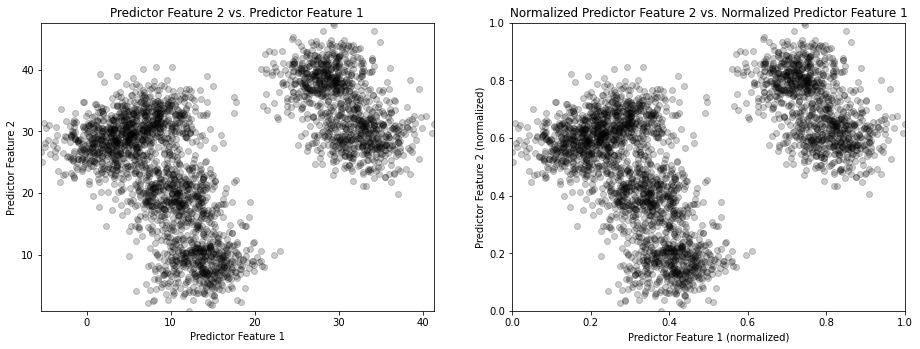

In [7]:
# scatter plot of our synthetic data  
plt.subplot(121)
plt.scatter(df['Feature1'], df['Feature2'], c="black", alpha = 0.2, linewidths=1.0, edgecolors="black")
plt.title('Predictor Feature 2 vs. Predictor Feature 1'); plt.xlabel('Predictor Feature 1'); plt.ylabel('Predictor Feature 2')
plt.xlim(Feature1min, Feature1max)
plt.ylim(Feature2min, Feature2max)

# scatter plot of our synthetic data (normalized)
plt.subplot(122)
plt.scatter(df['Norm_Feature1'], df['Norm_Feature2'], c="black", alpha = 0.2, linewidths=1.0, edgecolors="black")
plt.title('Normalized Predictor Feature 2 vs. Normalized Predictor Feature 1'); plt.xlabel('Predictor Feature 1 (normalized)'); plt.ylabel('Predictor Feature 2 (normalized)')
plt.xlim(0.0,1.0)
plt.ylim(0.0,1.0)
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.0, wspace=0.2, hspace=0.2)

### K-means Clustering (Heuristic) Workflow 

Our workflow consists of two main parts:

#### 1. K-mean demonstration with both classical and heuristic algorithms
Let’s apply K-means algorithm to our sample dataset using the KMeans class from scikit-learn's cluster module. Execution time was calculated for both algorithms. Clustering was performed on the normalized features.
* Firstly we use kmeans algorithm='full', which is a classical k-means clustering method.
* Following that, we use kmeans algorithm='elkan', which is a heuristic k-means clustering method.

#### 2. Sensitivity Analysis
If size of the data or its distribution is tweaked, heuristic algorithm (Elkan) might outperform the classical algorithm in terms of speed. Surprisingly, however, in most cases the classical algorithm finishes earlier than Elkan. So, it is unclear which algorithm performs better. Therefore, here we perform a sensitivity analysis to determine under which conditions Elkan method is preffered. 

There are several parameters that affect the performance of the KMeans algorithm:
* Number of clusters
* How well-defined are the clusters (we change it using standard deviation of the blobs in our synthetic data)
* Data size

### 1.1 K-mean demonstration with classical algorithms
Data created above is used to run classical K-means clustering algorithm on it.

Execution time for classical method is 0:00:00.076738


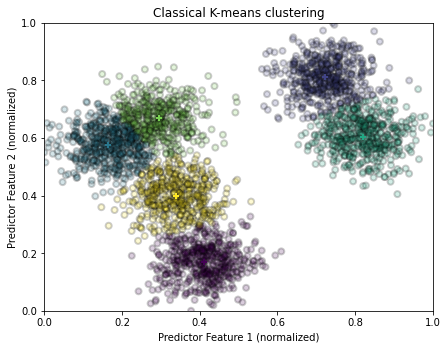

In [8]:
#Classic K-means clustering algorithm
df = df.reset_index(drop=True)

begin_time = datetime.datetime.now()
kmeans_norm = KMeans(n_clusters=K, random_state=42, algorithm='full').fit(df[['Norm_Feature1','Norm_Feature2']])
df = pd.concat([df, pd.DataFrame(kmeans_norm.labels_, columns=['Norm_Color'])], axis=1)

print("Execution time for classical method is " + str(datetime.datetime.now() - begin_time))

plt.subplot(111)                          # plot the training data and K prototypes
plt.scatter(df['Norm_Feature1'], df['Norm_Feature2'], c=df['Norm_Color'], alpha = 0.2, linewidths=2.0, edgecolors="black")
plt.scatter(kmeans_norm.cluster_centers_[:,0], kmeans_norm.cluster_centers_[:,1],marker='+',c=range(0,K),linewidths=2.0, edgecolors="black")
plt.title('Classical K-means clustering'); plt.xlabel('Predictor Feature 1 (normalized)'); plt.ylabel('Predictor Feature 2 (normalized)')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.subplots_adjust(left=0.5, bottom=0.0, right=1.4, top=1.0, wspace=0.2, hspace=0.2)

### 1.2 K-mean demonstration with heuristic (Elkan) algorithms
The same data as above is used to run the heuristic K-means clustering algorithm on it.

Execution time for heuristic (Elkan) method is 0:00:00.068091


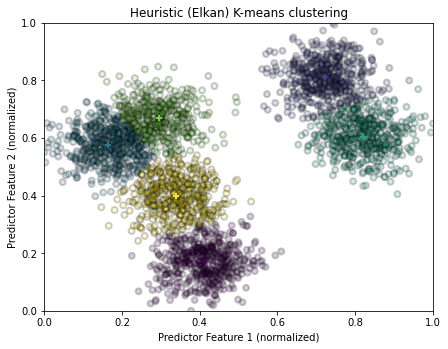

In [9]:
#Heuristic (Elkan) KMeans clustering algorithm
begin_time_heuristic = datetime.datetime.now()

kmeans_heuristic_norm = KMeans(n_clusters=K, random_state=42, algorithm='elkan').fit(df[['Norm_Feature1','Norm_Feature2']])
df = pd.concat([df, pd.DataFrame(kmeans_heuristic_norm.labels_, columns=['Norm_Color_heuristic'])], axis=1)

print("Execution time for heuristic (Elkan) method is " + str(datetime.datetime.now() - begin_time_heuristic))

plt.subplot(111)                          # plot the training data and K prototypes
plt.scatter(df['Norm_Feature1'], df['Norm_Feature2'], c=df['Norm_Color'], alpha = 0.2, linewidths=2.0, edgecolors="black")
plt.scatter(kmeans_heuristic_norm.cluster_centers_[:,0], kmeans_heuristic_norm.cluster_centers_[:,1],marker='+',c=range(0,K),linewidths=2.0, edgecolors="black")
plt.title('Heuristic (Elkan) K-means clustering'); plt.xlabel('Predictor Feature 1 (normalized)'); plt.ylabel('Predictor Feature 2 (normalized)')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.subplots_adjust(left=0.5, bottom=0.0, right=1.4, top=1.0, wspace=0.2, hspace=0.2)

### 2.1 Sensitivity Analysis on the number of clusters
Here I plot the execution time of each algorithm versus the number of clusters. I also plot the difference in the execution time which represents the speed up of the Elkan method. The same is done for the next two sections with other two parameters mentioned above.

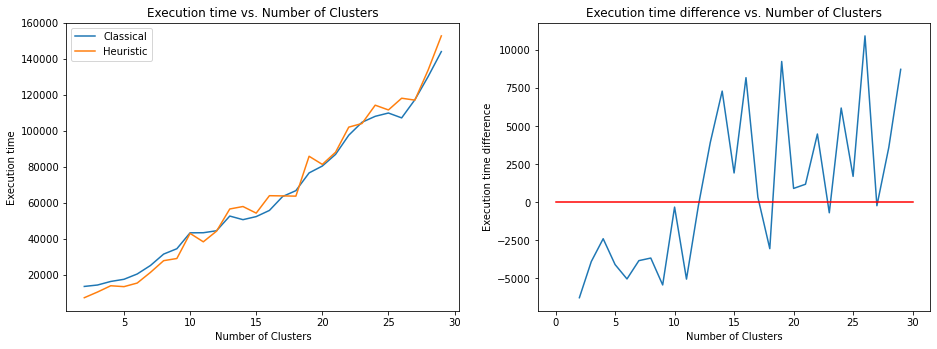

In [10]:
data_size = 200                                           

df_number_of_clusters = pd.DataFrame([], columns=['Number of Clusters', 'ET for classical', 'ET for heuristic'])

# Loop over different number of blobs
K_max = 30                                                                              
for K in range(2, K_max):                                                               
    # Creating the synthetic data similarly as above but with different numbers of blobs
    df = pd.DataFrame([])
    for i in range(0,K):
        df_ = pd.DataFrame(np.random.normal(size=(data_size,2),scale=0.5))
        df_.iloc[:,0] = df_.iloc[:,0] + 42*np.random.rand()
        df_.iloc[:,1] = df_.iloc[:,1] + 42*np.random.rand()
        df = pd.concat([df,df_])
    df.columns=['Feature1', 'Feature2']
    
    # Getting min and max of features and normalization
    Feature1min = df['Feature1'].min(); Feature1max = df['Feature1'].max()
    Feature2min = df['Feature2'].min(); Feature2max = df['Feature2'].max()
    df['Norm_Feature1'] = (df['Feature1']-Feature1min)/(Feature1max - Feature1min)
    df['Norm_Feature2'] = (df['Feature2']-Feature2min)/(Feature2max - Feature2min)

    df = df.reset_index(drop=True)
    
    # Measure execution time of classical K-means algorithm
    begin_time = datetime.datetime.now()
    kmeans_norm = KMeans(n_clusters=K, random_state=42, algorithm='full').fit(df[['Norm_Feature1','Norm_Feature2']])
    df = pd.concat([df, pd.DataFrame(kmeans_norm.labels_, columns=['Norm_Color'])], axis=1)
    ET_classical = datetime.datetime.now() - begin_time
    
    # Measure execution time of heuristic K-means algorithm
    begin_time_heuristic = datetime.datetime.now()
    kmeans_heuristic_norm = KMeans(n_clusters=K, random_state=42, algorithm='elkan').fit(df[['Norm_Feature1','Norm_Feature2']])
    df = pd.concat([df, pd.DataFrame(kmeans_heuristic_norm.labels_, columns=['Norm_Color_heuristic'])], axis=1)
    ET_heuristic = datetime.datetime.now() - begin_time_heuristic
    
    # Save to a DataFrame for plotting later
    df_temporary = pd.DataFrame({'Number of Clusters':[K],'ET for classical':[ET_classical.microseconds],'ET for heuristic':[ET_heuristic.microseconds]})
    df_number_of_clusters = pd.concat([df_number_of_clusters, df_temporary],ignore_index=True)
    
# Plot the execution times for both algorithm
plt.subplot(121)                          
plt.plot(df_number_of_clusters['Number of Clusters'],df_number_of_clusters['ET for classical'], label = 'Classical')
plt.plot(df_number_of_clusters['Number of Clusters'],df_number_of_clusters['ET for heuristic'], label = 'Heuristic')
plt.title('Execution time vs. Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Execution time')
plt.legend()
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.0, wspace=0.2, hspace=0.2)

# Plot the difference in the execution times of both algorithm
df_speedup = pd.DataFrame(df_number_of_clusters['ET for heuristic']-df_number_of_clusters['ET for classical'], columns=['Speed up'])
df_number_of_clusters = pd.concat([df_number_of_clusters,df_speedup],axis=1)
plt.subplot(122)                          
plt.plot(df_number_of_clusters['Number of Clusters'],df_number_of_clusters['Speed up'])
plt.plot([0,K_max],[0,0],color='r')
plt.title('Execution time difference vs. Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Execution time difference')
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.0, wspace=0.2, hspace=0.2)


### 2.2 Sensitivity Analysis on how well-defined are the clusters
As it was mentioned above, our data is synthetic which was created by randomly placing normally distributed blobs. Each blob has a standard deviation and when it is increased the blobs start to overlap which represents how well-defined are the clusters. Thus by changing the standard deviation when creating the data, we can do sensitivity analysis on how well-defined the clusters are.

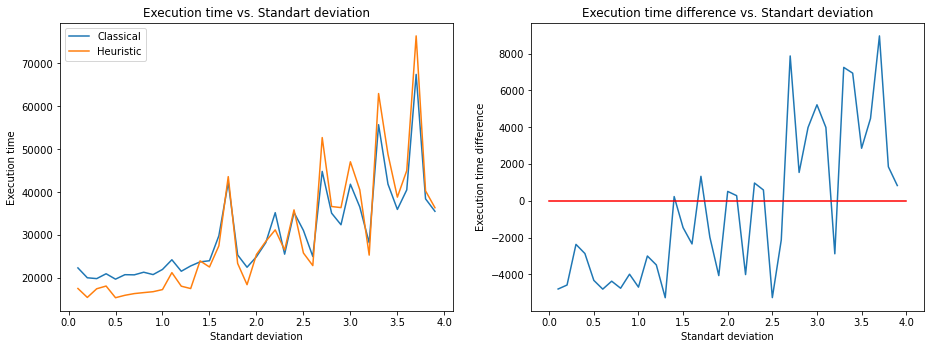

In [11]:
data_size = 300

df_standart_deviation = pd.DataFrame([], columns=['Standart deviation', 'ET for classical', 'ET for heuristic'])

# Loop over different standard deviations for each blob (higher the std, more likely the blobs to overlap)
std_max = 4
for std in np.arange(0.1, std_max, 0.1): 
    # Creating the synthetic data similarly as before but with different standard deviations for each blob
    df = pd.DataFrame([])
    K = 5
    for i in range(0,K):
        df_ = pd.DataFrame(np.random.normal(size=(data_size,2),scale = std))
        df_.iloc[:,0] = df_.iloc[:,0] + 42*np.random.rand()
        df_.iloc[:,1] = df_.iloc[:,1] + 42*np.random.rand()
        df = pd.concat([df,df_])
    df.columns=['Feature1', 'Feature2']
    
    # Getting min and max of features and normalization
    Feature1min = df['Feature1'].min(); Feature1max = df['Feature1'].max()
    Feature2min = df['Feature2'].min(); Feature2max = df['Feature2'].max()
    df['Norm_Feature1'] = (df['Feature1']-Feature1min)/(Feature1max - Feature1min)
    df['Norm_Feature2'] = (df['Feature2']-Feature2min)/(Feature2max - Feature2min)

    df = df.reset_index(drop=True)

    # Measure execution time of classical K-means algorithm
    begin_time = datetime.datetime.now()
    kmeans_norm = KMeans(n_clusters=K, random_state=42, algorithm='full').fit(df[['Norm_Feature1','Norm_Feature2']])
    df = pd.concat([df, pd.DataFrame(kmeans_norm.labels_, columns=['Norm_Color'])], axis=1)
    ET_classical = datetime.datetime.now() - begin_time

    # Measure execution time of heuristic K-means algorithm
    begin_time_heuristic = datetime.datetime.now()
    kmeans_heuristic_norm = KMeans(n_clusters=K, random_state=42, algorithm='elkan').fit(df[['Norm_Feature1','Norm_Feature2']])
    df = pd.concat([df, pd.DataFrame(kmeans_heuristic_norm.labels_, columns=['Norm_Color_heuristic'])], axis=1)
    ET_heuristic = datetime.datetime.now() - begin_time_heuristic
    
    # Save to a DataFrame for plotting later
    df_temporary = pd.DataFrame({'Standart deviation':[std],'ET for classical':[ET_classical.microseconds],'ET for heuristic':[ET_heuristic.microseconds]})
    df_standart_deviation = pd.concat([df_standart_deviation, df_temporary],ignore_index=True)

# Plot the execution times for both algorithm
plt.subplot(121)
plt.plot(df_standart_deviation['Standart deviation'],df_standart_deviation['ET for classical'], label = 'Classical')
plt.plot(df_standart_deviation['Standart deviation'],df_standart_deviation['ET for heuristic'], label = 'Heuristic')
plt.title('Execution time vs. Standart deviation')
plt.xlabel('Standart deviation')
plt.ylabel('Execution time')
plt.legend()
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.0, wspace=0.2, hspace=0.2)

# Plot the difference in the execution times of both algorithm
df_speedup = pd.DataFrame(df_standart_deviation['ET for heuristic']-df_standart_deviation['ET for classical'], columns=['Speed up'])
df_standart_deviation = pd.concat([df_standart_deviation,df_speedup],axis=1)
plt.subplot(122)                          
plt.plot(df_standart_deviation['Standart deviation'],df_standart_deviation['Speed up'])
plt.plot([0,std_max],[0,0],color='r')
plt.title('Execution time difference vs. Standart deviation')
plt.xlabel('Standart deviation')
plt.ylabel('Execution time difference')
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.0, wspace=0.2, hspace=0.2)



### 2.3 Sensitivity Analysis on the size of the dataset
The final sensitivity analysis is done on the number of data points in each blob. This is directly proportional to a number of data points in the entire dataset. Thus, we want to see if there is a limit to a data size after which Elkan algorithm is no longer efficient.

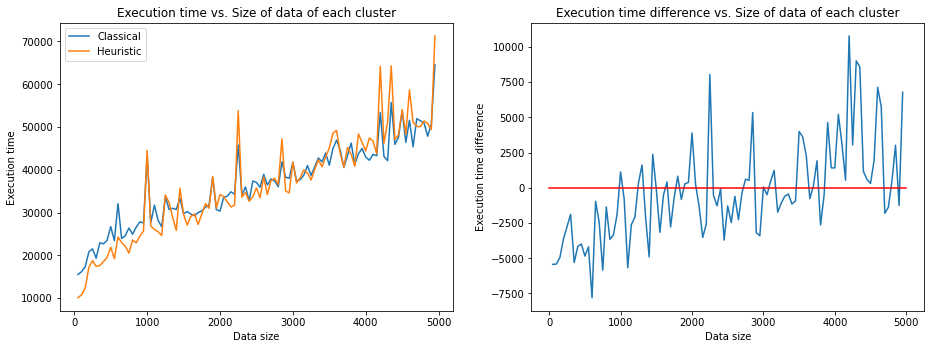

In [12]:
data_size_max = 5000

df_data_size = pd.DataFrame([], columns=['Data size', 'ET for classical', 'ET for heuristic'])

# Loop over different data size values for each blob
for data_size in np.arange(50, data_size_max, 50):
    # Creating the synthetic data similarly as before but with different data size values for each blob
    df = pd.DataFrame([])
    K = 5
    for i in range(0,K):
        df_ = pd.DataFrame(np.random.normal(size=(data_size,2),scale = 0.5))
        df_.iloc[:,0] = df_.iloc[:,0] + 42*np.random.rand()
        df_.iloc[:,1] = df_.iloc[:,1] + 42*np.random.rand()
        df = pd.concat([df,df_])
    df.columns=['Feature1', 'Feature2']

    # Getting min and max of features and normalization
    Feature1min = df['Feature1'].min(); Feature1max = df['Feature1'].max()
    Feature2min = df['Feature2'].min(); Feature2max = df['Feature2'].max()
    df['Norm_Feature1'] = (df['Feature1']-Feature1min)/(Feature1max - Feature1min)
    df['Norm_Feature2'] = (df['Feature2']-Feature2min)/(Feature2max - Feature2min)

    df = df.reset_index(drop=True)

    # Measure execution time of classical K-means algorithm
    begin_time = datetime.datetime.now()
    kmeans_norm = KMeans(n_clusters=K, random_state=42, algorithm='full').fit(df[['Norm_Feature1','Norm_Feature2']])
    df = pd.concat([df, pd.DataFrame(kmeans_norm.labels_, columns=['Norm_Color'])], axis=1)
    ET_classical = datetime.datetime.now() - begin_time

    # Measure execution time of heuristic K-means algorithm
    begin_time_heuristic = datetime.datetime.now()
    kmeans_heuristic_norm = KMeans(n_clusters=K, random_state=42, algorithm='elkan').fit(df[['Norm_Feature1','Norm_Feature2']])
    df = pd.concat([df, pd.DataFrame(kmeans_heuristic_norm.labels_, columns=['Norm_Color_heuristic'])], axis=1)
    ET_heuristic = datetime.datetime.now() - begin_time_heuristic
    
    # Save to a DataFrame for plotting later
    df_temporary = pd.DataFrame({'Data size':[data_size],'ET for classical':[ET_classical.microseconds],'ET for heuristic':[ET_heuristic.microseconds]})
    df_data_size = pd.concat([df_data_size, df_temporary],ignore_index=True)

# Plot the execution times for both algorithm
plt.subplot(121)
plt.plot(df_data_size['Data size'],df_data_size['ET for classical'], label = 'Classical')
plt.plot(df_data_size['Data size'],df_data_size['ET for heuristic'], label = 'Heuristic')
plt.title('Execution time vs. Size of data of each cluster')
plt.xlabel('Data size')
plt.ylabel('Execution time')
plt.legend()
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.0, wspace=0.2, hspace=0.2)

# Plot the difference in the execution times of both algorithm
df_speedup = pd.DataFrame(df_data_size['ET for heuristic']-df_data_size['ET for classical'], columns=['Speed up'])
df_data_size = pd.concat([df_data_size,df_speedup],axis=1)
plt.subplot(122)                          
plt.plot(df_data_size['Data size'],df_data_size['Speed up'])
plt.plot([0,data_size_max],[0,0],color='r')
plt.title('Execution time difference vs. Size of data of each cluster')
plt.xlabel('Data size')
plt.ylabel('Execution time difference')
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.0, wspace=0.2, hspace=0.2)


### Results

In this project it was observed that Elkan (heuristic) algorithm is performing better than classical Lloyd's algorithm under certain conditions.

* Cluster size should preferably be less than 10, otherwise Elkan execution time increases too much, because it is more memory-intensive due to the allocation of an extra array.
* Clusters should be well defined in the dataset as it was seen from sensitivity analysis on the standard deviation above. 
* There is also an upper limit for data size above which Elkan is taking more time than classical method. The reason for that is again an allocation of an extra memory.

### Elnara Rustamzade, PhD Student, University of Texas at Austin
*Geomodeling with data analytics and machine learning*

#### [LinkedIn](https://www.linkedin.com/in/elnara-rustamzade-779396162/) | [GitHub](https://github.com/ElnaraRustamzade) 

I hope this was helpful. Please feel free to contact me with any questions. I am open to any internship opportunities as a Data Scientist / Petroleum Engineer.

*Elnara*